# Prediction of Cancer Metastasis in Lymph Nodes Whole-slide Image Patches with CNN


### load packages and prep

In [4]:
import h5py
import numpy as np
import torch
import os
import pandas as pd
import PIL.Image
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import time
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
from os import listdir
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets
import logging
from sk
n.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



drive_base_path = '/home/ubuntu/pcamv1/'
BATCH_SIZE = 64
CHECKPOINT_DIR = 'Checkpoint_V1'
logging.basicConfig(filename='training_log_v3.log', level=logging.INFO, format='%(asctime)s - %(message)s')

In [5]:
!ls /home/ubuntu/pcamv1

camelyonpatch_level_2_split_test_meta.csv
camelyonpatch_level_2_split_test_x.h5
camelyonpatch_level_2_split_test_y.h5
camelyonpatch_level_2_split_train_mask.h5
camelyonpatch_level_2_split_train_meta.csv
camelyonpatch_level_2_split_train_x.h5
camelyonpatch_level_2_split_train_y.h5
camelyonpatch_level_2_split_valid_meta.csv
camelyonpatch_level_2_split_valid_x.h5
camelyonpatch_level_2_split_valid_y.h5


### dataset

In [69]:
class H5Dataset(Dataset):
    '''used with PyTorch’s Dataset interface for handling datasets stored in HDF5 file format'''

    def __init__(self, path, transform=None):
        self.file_path = path
        self.dataset_x = None
        self.dataset_y = None
        self.transform = transform
        ### Going to read the X part of the dataset - it's a different file
        with h5py.File(self.file_path + '_x.h5', 'r') as filex:
            self.dataset_x_len = len(filex['x'])

        ### Going to read the y part of the dataset - it's a different file
        with h5py.File(self.file_path + '_y.h5', 'r') as filey:
            self.dataset_y_len = len(filey['y'])

    def __getitem__(self, index):
        imgs_path = self.file_path + '_x.h5'
        labels_path = self.file_path + '_y.h5'

        if self.dataset_x is None:
            self.dataset_x = h5py.File(imgs_path, 'r')['x']
        if self.dataset_y is None:
            self.dataset_y = h5py.File(labels_path, 'r')['y']

        # get one pair of X, Y and return them, transform if needed
        image = self.dataset_x[index]
        label = self.dataset_y[index]

        if self.transform:
            image = self.transform(image)

        return (image, label)

    def __len__(self):
        assert self.dataset_x_len == self.dataset_y_len
        return self.dataset_x_len

### model

In [9]:
class CNN_V2(nn.Module):
    """The model inheretes from nn.Module"""
    def __init__(self, p = 0.5): #dropout probability p
        super(CNN_V2, self).__init__()
        ######## 1. Convolutional layers
        # Single image is in shape: 3x96x96 (CxHxW, H==W), RGB images
        # Four convolutional layers with increasing numbers of output channels (16, 32, 64, 128)
        # Batch normalization is applied after each convolutional layer
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)

        # A max-pooling layer with a kernel size of 2 and stride of 2 that reduces the spatial dimensions (H & W) by half
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        # A dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p = p)

        ######## 2. FC layers to final output
        # Four fully connected layers (Linear) to map the learned features to the final output
        # The first three FC layers are followed by batch normalization and ReLU activation
        # The final FC layer outputs the final prediction
        # features drop from 521-256-128-1
        self.fc1 = nn.Linear(in_features = 128*6*6, out_features = 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(in_features = 256, out_features = 128)
        self.fc_bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(in_features = 128, out_features = 1)

    def forward(self, x):
        # Apply 4x...
        # Convolution Layers, followed by Batch Normalizations, Maxpool, and ReLU
        x = self.bn1(self.conv1(x))                      # batch_size x 96 x 96 x 16
        x = self.pool(F.relu(x))                         # batch_size x 48 x 48 x 16
        x = self.bn2(self.conv2(x))                      # batch_size x 48 x 48 x 32
        x = self.pool(F.relu(x))                         # batch_size x 24 x 24 x 32
        x = self.bn3(self.conv3(x))                      # batch_size x 24 x 24 x 64
        x = self.pool(F.relu(x))                         # batch_size x 12 x 12 x 64
        x = self.bn4(self.conv4(x))                      # batch_size x 12 x 12 x 128
        x = self.pool(F.relu(x))                         # batch_size x  6 x  6 x 128
        # Flatten the output for each image
        x = x.reshape(-1, self.num_flat_features(x))        # batch_size x 6*6*128

        # Apply 4 FC Layers
        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.fc_bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.fc_bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        '''calculates the total number of features in a flattened tensor, excluding the batch dimension.
        If x is a 4D tensor with shape [batch_size, channels, height, width], it calculates channels * height * width'''
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### helper functions

In [10]:
def sigmoid(x):
    """This method calculates the sigmoid function"""
    return 1.0/(1.0 + np.exp(-x))

def training_accuracy(predicted, true, i, acc, tpr, tnr):
    ''' '''
    # predicted is the logit we get from the fc layer
    predicted = predicted.cpu() # send to cpu for numpy calculation
    true = true.cpu()

    # use sigmoid to map to probability, and 0.5 threshold
    predicted = (sigmoid(predicted.data.numpy()) > 0.5) # Using sigmoid above, if prediction > 0.5 it is 1
    true = true.data.numpy() # true lable is 0 or 1

    accuracy = np.sum(predicted == true) / true.shape[0] # Accuracy is: (TP + TN)/(TP + TN + FN + FP)
    true_positive_rate = np.sum((predicted == 1) * (true == 1)) / np.sum(true == 1) # TPR: TP / (TP + FN) aka Recall
    true_negative_rate = np.sum((predicted == 0) * (true == 0)) / np.sum(true == 0) # TNR: TN / (FP + TN)

    # update the cumulative metrics (accuracy, TPR, TNR) over multiple batches or iterations.
    # i is the index of the current batch or iteration
    acc = acc * (i) / (i + 1) + accuracy / (i + 1)
    tpr = tpr * (i) / (i + 1) + true_positive_rate / (i + 1)
    tnr = tnr * (i) / (i + 1) + true_negative_rate / (i + 1)
    return acc, tpr, tnr

def dev_accuracy(predicted, target):
    predicted = predicted.cpu()
    target = target.cpu()
    predicted = (sigmoid(predicted.data.numpy()) > 0.5)
    true = target.data.numpy()
    accuracy = np.sum(predicted == true) / true.shape[0]
    true_positive_rate = np.sum((predicted == 1) * (true == 1)) / np.sum(true == 1)
    true_negative_rate = np.sum((predicted == 0) * (true == 0)) / np.sum(true == 0)
    return accuracy, true_positive_rate, true_negative_rate


def fetch_state(epoch, model, optimizer, dev_loss_min, dev_acc_max):
    """Returns the state dictionary for a model and optimizer"""
    state = {
        'epoch': epoch,
        'dev_loss_min': dev_loss_min,
        'dev_acc_max': dev_acc_max,
        'state_dict': model.state_dict(),
        'optim_dict': optimizer.state_dict()
    }
    return state

def save_checkpoint(state, is_best = False, checkpoint = CHECKPOINT_DIR):
    """To save the current state of the model, and optionally mark it as the best model if it has the best performance so far.
    Saves model and training parameters at checkpoint + 'last.pth.tar'.
    If is_best==True, also saves checkpoint + 'best.pth.tar'

    Args:
        state: A dictionary containing the model's state_dict and possibly other information like the current epoch, optimizer state, etc.
        is_best: A boolean indicating whether the current model is the best one seen so far.
        checkpoint: The directory where the checkpoint files will be saved.
    """
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if (not os.path.exists(checkpoint)):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    else:
        print("Checkpoint Directory exists. ")
    torch.save(state, filepath)
    if (is_best):
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))

def load_checkpoint(model, optimizer = None, checkpoint = CHECKPOINT_DIR):
    """To load a model's parameters from a saved checkpoint file.
    It can also load the state of the optimizer if provided.

    Args:
        checkpoint: The file path of the checkpoint to load.
        model: The PyTorch model (torch.nn.Module) whose parameters are to be loaded.
        optimizer: An optional PyTorch optimizer (torch.optim) whose state may also be restored.
    """
    if not os.path.exists(checkpoint):
        print("File doesn't exist {}".format(checkpoint))
        checkpoint = None
        return
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint

In [ ]:
## wrap it up in a function
def train_evaluate(model, train_loader, dev_loader, optimizer, criterion, total_epochs, num_epochs, use_gpu, early_stop_limit, dev_loss_min=np.Inf, dev_acc_max=0):
    total_num_epochs = total_epochs + num_epochs
    bad_epoch_count = 0
    stop = False
    # Initialize arrays for plot
    train_loss_arr = []
    train_acc_arr = []
    train_tpr_arr = []
    train_tnr_arr = []

    dev_loss_arr = []
    dev_acc_arr = []
    dev_tpr_arr = []
    dev_tnr_arr = []

    for epoch in range(num_epochs):
        curr_epoch = total_epochs + epoch + 1  # epoch is the current idx
        train_loss = []
        dev_loss = []
        acc, tpr, tnr = 0.0, 0.0, 0.0

        # Train the model
        start_time = time.time()
        model.train()

        for batch_idx, (images, labels) in enumerate(train_loader):
            if use_gpu:
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)

            # Calculate the batch's loss
            loss = criterion(outputs, labels.view(-1, 1).float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            # Get accuracy measurements
            acc, tpr, tnr = training_accuracy(outputs, labels.view(-1, 1).float(), batch_idx, acc, tpr, tnr) 

            if batch_idx % 32 == 0:
                logging.info(f'Epoch {curr_epoch}/{total_num_epochs}; Iter {batch_idx + 1}/{len(train_loader)}; '
                             f'Loss: {loss.item():.4f}; Acc: {acc:.3f}; TPR: {tpr:.3f}; TNR: {tnr:.3f}')
        end_time = time.time()

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(dev_loader):
                if use_gpu:
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                
                # Calculate the batch's loss
                dev_loss_val = criterion(outputs, labels.view(-1, 1).float())
                dev_loss.append(dev_loss_val.item())

                # Get accuracy measurements
                dev_acc, dev_tpr, dev_tnr = dev_accuracy(outputs, labels.view(-1, 1))

            # Calculate average loss
            avg_train_loss = np.mean(np.array(train_loss))
            avg_dev_loss = np.mean(np.array(dev_loss))

            # Update dev loss arrays
            dev_loss_arr.append(avg_dev_loss)
            dev_acc_arr.append(dev_acc)
            dev_tpr_arr.append(dev_tpr)
            dev_tnr_arr.append(dev_tnr)

            # Update training loss arrays
            train_loss_arr.append(avg_train_loss)
            train_acc_arr.append(acc)
            train_tpr_arr.append(tpr)
            train_tnr_arr.append(tnr)
        # Log the epoch's metrics
        logging.info(f'Epoch {curr_epoch}/{total_num_epochs}; Avg. Train Loss: {avg_train_loss:.4f}; '
                     f'Train Acc: {acc:.3f}; Train TPR: {tpr:.3f}; Train TNR: {tnr:.3f}; '
                     f'Epoch Time: {round((end_time - start_time) / 60., 2)} mins; '
                     f'Avg. Dev Loss: {avg_dev_loss:.4f}; Dev Acc: {dev_acc:.3f}; '
                     f'Dev TPR: {dev_tpr:.3f}; Dev TNR: {dev_tnr:.3f}')

        # Check for early stopping conditions
        if avg_dev_loss < dev_loss_min:
            logging.info('Dev loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(dev_loss_min, avg_dev_loss))
            dev_loss_min = avg_dev_loss
            is_best = False
            if (dev_acc >= dev_acc_max):
                is_best = True
                dev_acc_max = dev_acc
            state = fetch_state( epoch = curr_epoch
                            , model = model
                            , optimizer = optimizer
                            , dev_loss_min = dev_loss_min
                            , dev_acc_max = dev_acc_max )
            save_checkpoint( state = state
                            , is_best = is_best )
            bad_epoch_count = 0
        else:
            bad_epoch_count += 1
            logging.info('{} epochs of increasing dev loss ({:.6f} --> {:.6f}).'
              .format(bad_epoch_count, dev_loss_min, avg_dev_loss))
            if bad_epoch_count >= early_stop_limit:
                logging.info('Early stopping')
                stop = True

        if stop:
            break

    return model, train_loss_arr, train_acc_arr, train_tpr_arr, train_tnr_arr, dev_loss_arr, dev_acc_arr, dev_tpr_arr, dev_tnr_arr

### setup for training

In [ ]:
BATCH_SIZE = 64
CHECKPOINT_DIR = 'Checkpoint_V1'
logging.basicConfig(filename='training_log_v3.log', level=logging.INFO, format='%(asctime)s - %(message)s')

In [58]:
########## Parameters

# total_num_epochs, the # of epochs intended to run
# total_epochs, the # of epochs already trained for
# num_epochs, the # of epochs to train for during the current training session

num_workers = 4
total_epochs = 0
num_epochs = 30
early_stop_limit = 10
bad_epoch_count = 0
stop = False
train_loss_min = np.Inf
dev_loss_min = np.Inf
dev_acc_max = 0

In [59]:
########## Model initialization
USE_GPU = torch.cuda.is_available()

model = CNN_V2()
if (USE_GPU):
    model = model.cuda()
    model = nn.DataParallel(model)

In [60]:
########## data augmentation
# random vertical and horizontal flips, conversion to a tensor, and normalization of the pixel values.
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataloader_params = {'batch_size': BATCH_SIZE, 'shuffle': True, 'num_workers': 4}

train_path = drive_base_path + 'camelyonpatch_level_2_split_train'
val_path = drive_base_path + 'camelyonpatch_level_2_split_valid'
test_path = drive_base_path + 'camelyonpatch_level_2_split_test'

test_dataset = H5Dataset(test_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, **dataloader_params)

val_dataset = H5Dataset(val_path, transform=test_transforms)
dev_loader = DataLoader(val_dataset, **dataloader_params)

train_dataset = H5Dataset(train_path, transform=train_transforms)
train_loader = DataLoader(train_dataset, **dataloader_params)


In [61]:
# print to check the loader works as expected

for x, y in train_loader:
  print(x.shape)
  print(y.shape)
  break

for x, y in dev_loader:
  print(x.shape)
  print(y.shape)
  break

for x, y in test_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([16, 3, 96, 96])
torch.Size([16, 1, 1, 1])
torch.Size([16, 3, 96, 96])
torch.Size([16, 1, 1, 1])
torch.Size([16, 3, 96, 96])
torch.Size([16, 1, 1, 1])


In [62]:
# Hyperparameters
lr = 5e-4

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)
#optimizer = optim.SGD(model.parameters(), lr = lr)

criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy for binary classification - malignant / benign

# Load best checkpoint
# best_checkpoint = os.path.join(CHECKPOINT_DIR, 'best_v2.pth.tar');
# checkpoint = load_checkpoint(model = model, optimizer = optimizer, checkpoint = best_checkpoint)
# checkpoint = load_checkpoint(model = model, optimizer = None, checkpoint = best_checkpoint) # SWATS
# total_epochs = None if checkpoint is None else checkpoint['epoch']
# total_epochs = 0

# Initialize arrays for plot
train_loss_arr = []
train_acc_arr = []
train_tpr_arr = []
train_tnr_arr = []

dev_loss_arr = []
dev_acc_arr = []
dev_tpr_arr = []
dev_tnr_arr = []

### train and evaluation

In [45]:
# Loop over the dataset multiple times

total_num_epochs = total_epochs + num_epochs

for epoch in range(num_epochs):
    curr_epoch = total_epochs + epoch + 1 # epoch is the current idx

    train_loss = []
    dev_loss = []
    acc, tpr, tnr = 0.0, 0.0, 0.0

    # Train the model
    start_time = time.time()
    model.train()

    for batch_idx, (image, label) in enumerate(train_loader):
        if USE_GPU:
            data, target = image.cuda(), label.cuda()
        else:
            data, target = image, label

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # original data in the format [batch_size, height, width, channels]
        # reformat to [batch_size, channels, height, width]
        # data = data.permute(0, 3, 1, 2).float()

        output = model(data)

        # view(output.shape[0], 1) reshapes the target tensor to have the same batch size as output with a second dimension of size 1
        target = target.view(output.shape[0], 1).float()

        # Get accuracy measurements
        acc, tpr, tnr = training_accuracy(output, target, batch_idx, acc, tpr, tnr)

        # Calculate the batch's loss
        curr_train_loss = criterion(output, target)

        # Update the training loss
        train_loss.append(curr_train_loss.item())

        # Backward pass
        curr_train_loss.backward() # The .backward() method computes the gradient of the loss with respect to each parameter of the model that has requires_grad=True.

        # Perform a single optimization step to update parameters
        optimizer.step()

        # Print debug info every 32 batches
        if (batch_idx) % 32 == 0:
            print('Epoch {}/{}; Iter {}/{}; Loss: {:.4f}; Acc: {:.3f}; True Pos: {:.3f}; True Neg: {:.3f}'
                   .format(curr_epoch, total_num_epochs, batch_idx + 1, len(train_loader), curr_train_loss.item(), acc, tpr, tnr))
            logging.info('Epoch {}/{}; Iter {}/{}; Loss: {:.4f}; Acc: {:.3f}; True Pos: {:.3f}; True Neg: {:.3f}'
                   .format(curr_epoch, total_num_epochs, batch_idx + 1, len(train_loader), curr_train_loss.item(), acc, tpr, tnr))

    end_time = time.time()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(dev_loader):
            if USE_GPU:
                data, target = image.cuda(), label.cuda()
            else:
                data, target = image, label

            # Get predicted output
            # data = data.permute(0, 3, 1, 2).float()
            output = model(data)

            # Update target to be the same dimensions as output
            target = target.view(output.shape[0], 1).float()

            # Get accuracy measurements
            dev_acc, dev_tpr, dev_tnr = dev_accuracy(output, target)

            # Calculate the batch's loss
            curr_dev_loss = criterion(output, target)
            # Update the dev loss
            dev_loss.append(curr_dev_loss.item())

    # Calculate average loss
    avg_train_loss = np.mean(np.array(train_loss))
    avg_dev_loss = np.mean(np.array(dev_loss))

    # Update dev loss arrays
    dev_loss_arr.append(avg_dev_loss)
    dev_acc_arr.append(dev_acc)
    dev_tpr_arr.append(dev_tpr)
    dev_tnr_arr.append(dev_tnr)

    # Update training loss arrays
    train_loss_arr.append(avg_train_loss)
    train_acc_arr.append(acc)
    train_tpr_arr.append(tpr)
    train_tnr_arr.append(tnr)

    print('Epoch {}/{}; Avg. Train Loss: {:.4f}; Train Acc: {:.3f}; Train TPR: {:.3f}; Train TNR: {:.3f}; Epoch Time: {} mins; \nAvg. Dev Loss: {:.4f}; Dev Acc: {:.3f}; Dev TPR: {:.3f}; Dev TNR: {:.3f}\n'
        .format(curr_epoch, total_num_epochs, avg_train_loss, acc, tpr, tnr, round((end_time - start_time)/ 60., 2), avg_dev_loss, dev_acc, dev_tpr, dev_tnr))
    logging.info('Epoch {}/{}; Avg. Train Loss: {:.4f}; Train Acc: {:.3f}; Train TPR: {:.3f}; Train TNR: {:.3f}; Epoch Time: {} mins; \nAvg. Dev Loss: {:.4f}; Dev Acc: {:.3f}; Dev TPR: {:.3f}; Dev TNR: {:.3f}\n'
        .format(curr_epoch, total_num_epochs, avg_train_loss, acc, tpr, tnr, round((end_time - start_time)/ 60., 2), avg_dev_loss, dev_acc, dev_tpr, dev_tnr))

    if avg_dev_loss < dev_loss_min:
        print('Dev loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(dev_loss_min, avg_dev_loss))
        logging.info('Dev loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(dev_loss_min, avg_dev_loss))
        dev_loss_min = avg_dev_loss
        is_best = False
        if (dev_acc >= dev_acc_max):
            is_best = True
            dev_acc_max = dev_acc
        state = fetch_state( epoch = curr_epoch
                            , model = model
                            , optimizer = optimizer
                            , dev_loss_min = dev_loss_min
                            , dev_acc_max = dev_acc_max )
        save_checkpoint( state = state
                        , is_best = is_best )
        bad_epoch_count = 0

    # If dev loss didn't improve, increase bad_epoch_count and stop if
    # bad_epoch_count >= early_stop_limit
    else:
        bad_epoch_count += 1
        print('{} epochs of increasing dev loss ({:.6f} --> {:.6f}).'
              .format(bad_epoch_count, dev_loss_min, avg_dev_loss))
        logging.info('{} epochs of increasing dev loss ({:.6f} --> {:.6f}).'
              .format(bad_epoch_count, dev_loss_min, avg_dev_loss))
        if (bad_epoch_count >= early_stop_limit):
            print('Stopping training')
            logging.info('Stopping training')
            stop = True

    if (stop):
        break

Epoch 1/10; Iter 1/4096; Loss: 0.6792; Acc: 0.609; True Pos: 0.488; True Neg: 0.826
Epoch 1/10; Iter 33/4096; Loss: 0.4772; Acc: 0.732; True Pos: 0.722; True Neg: 0.751
Epoch 1/10; Iter 65/4096; Loss: 0.4308; Acc: 0.751; True Pos: 0.747; True Neg: 0.762
Epoch 1/10; Iter 97/4096; Loss: 0.3444; Acc: 0.762; True Pos: 0.769; True Neg: 0.762
Epoch 1/10; Iter 129/4096; Loss: 0.4839; Acc: 0.768; True Pos: 0.777; True Neg: 0.766
Epoch 1/10; Iter 161/4096; Loss: 0.5030; Acc: 0.775; True Pos: 0.783; True Neg: 0.773
Epoch 1/10; Iter 193/4096; Loss: 0.4385; Acc: 0.779; True Pos: 0.786; True Neg: 0.780
Epoch 1/10; Iter 225/4096; Loss: 0.3256; Acc: 0.785; True Pos: 0.791; True Neg: 0.786
Epoch 1/10; Iter 257/4096; Loss: 0.5662; Acc: 0.788; True Pos: 0.796; True Neg: 0.788
Epoch 1/10; Iter 289/4096; Loss: 0.4782; Acc: 0.791; True Pos: 0.800; True Neg: 0.790
Epoch 1/10; Iter 321/4096; Loss: 0.4286; Acc: 0.795; True Pos: 0.804; True Neg: 0.792
Epoch 1/10; Iter 353/4096; Loss: 0.3901; Acc: 0.798; True P

#### plotting

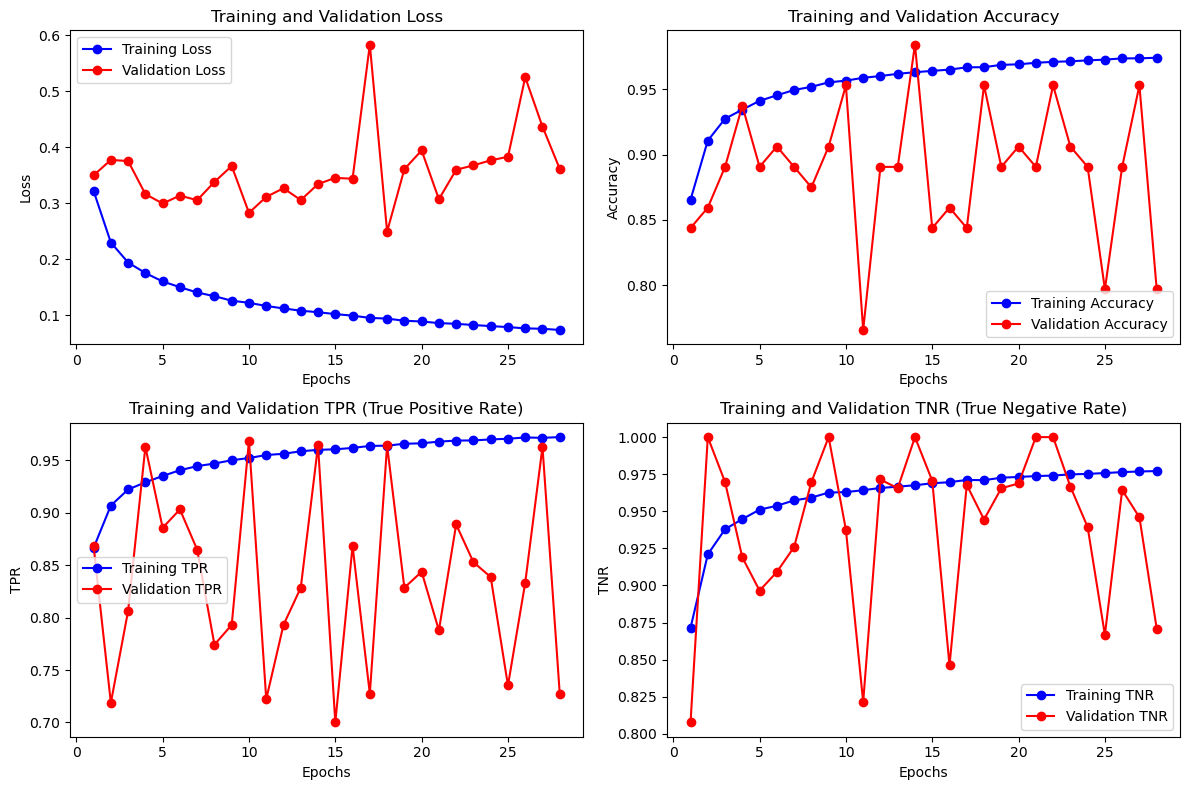

In [53]:
# plotting
epochs = range(1, len(train_loss_arr) + 1)

# Plot for Training and Validation Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_arr, 'bo-', label='Training Loss')
plt.plot(epochs, dev_loss_arr, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_arr, 'bo-', label='Training Accuracy')
plt.plot(epochs, dev_acc_arr, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for Training and Validation TPR
plt.subplot(2, 2, 3)
plt.plot(epochs, train_tpr_arr, 'bo-', label='Training TPR')
plt.plot(epochs, dev_tpr_arr, 'ro-', label='Validation TPR')
plt.title('Training and Validation TPR (True Positive Rate)')
plt.xlabel('Epochs')
plt.ylabel('TPR')
plt.legend()

# Plot for Training and Validation TNR
plt.subplot(2, 2, 4)
plt.plot(epochs, train_tnr_arr, 'bo-', label='Training TNR')
plt.plot(epochs, dev_tnr_arr, 'ro-', label='Validation TNR')
plt.title('Training and Validation TNR (True Negative Rate)')
plt.xlabel('Epochs')
plt.ylabel('TNR')
plt.legend()

plt.tight_layout()
plt.show()


#### save model and training stats

In [54]:
import pickle

# Bundle your data into a dictionary
data = {
    "train_loss_arr": train_loss_arr,
    "train_acc_arr": train_acc_arr,
    "train_tpr_arr": train_tpr_arr,
    "train_tnr_arr": train_tnr_arr,
    "dev_loss_arr": dev_loss_arr,
    "dev_acc_arr": dev_acc_arr,
    "dev_tpr_arr": dev_tpr_arr,
    "dev_tnr_arr": dev_tnr_arr
}

# Save the data with pickle
with open('v1_batch64epoch30.pkl', 'wb') as f:
    pickle.dump(data, f)


In [71]:
''' ## if need to read again
with open('v1_batch64epoch30.pkl', 'rb') as f:
    data = pickle.load(f)

# Accessing the data
train_loss_arr = data["train_loss_arr"]
train_acc_arr = data["train_acc_arr"]
train_tpr_arr = data["train_tpr_arr"]
train_tnr_arr = data["train_tnr_arr"]

dev_loss_arr = data["dev_loss_arr"]
dev_acc_arr = data["dev_acc_arr"]
dev_tpr_arr = data["dev_tpr_arr"]
dev_tnr_arr = data["dev_tnr_arr"]
'''

In [56]:
# save the model, the original model is wrapped in DataParallel
# Generate a dummy input
example_input = torch.rand(1, 3, 96, 96)
if USE_GPU:
    example_input = example_input.cuda()

# Trace the original model (which is stored in model.module)
traced_script_module = torch.jit.trace(model.module, example_input)

# Save the traced model
full_filename = "v1_model_batch64epoch30.pt"
traced_script_module.save(full_filename)

In [81]:
'''
# Load the traced model
full_filename = "v1_model_batch64epoch30.pt"
model = torch.jit.load(full_filename)

# If using GPU for inference and you want to utilize DataParallel, wrap it again
if USE_GPU:
    model = model.cuda()
    model = nn.DataParallel(model)
'''

#### test

In [83]:
model.eval()  # set the model to evaluation mode

all_predictions = []
all_targets = []
with torch.no_grad():
        for _,  (image, label) in enumerate(test_loader):
            if USE_GPU:
                data, target = image.cuda(), label.cuda()
            else:
                data, target = image, label

            # Get predicted output
            # data = data.permute(0, 3, 1, 2).float()
            output = model(data)

            # Update target to be the same dimensions as output
            target = target.view(output.shape[0], 1).float()

            # Get accuracy measurements
            #test_acc, test_tpr, test_tnr = dev_accuracy(output, target)
            predicted = output.cpu()
            target = target.cpu()
            predicted = (sigmoid(predicted.data.numpy()) > 0.5)
            true = target.data.numpy()

            all_predictions.extend(predicted)
            all_targets.extend(true)
           

In [84]:
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy: 0.8279, Precision: 0.8528, Recall: 0.8279, F1-Score: 0.8248


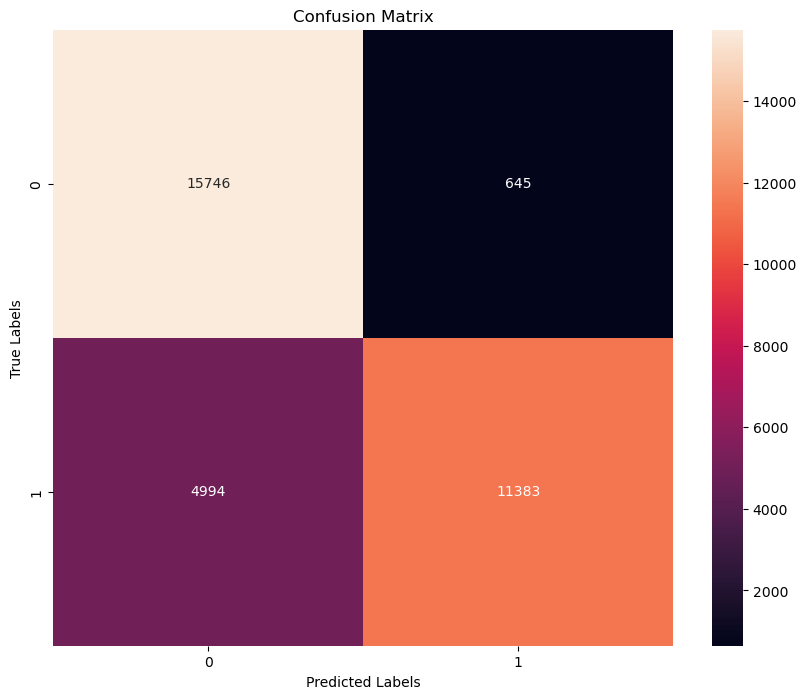

In [85]:
conf_matrix = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Plot correctly and incorrectly classified images for both true and false labels

In [ ]:
correct_true_label = []
correct_false_label = []
incorrect_true_label = []
incorrect_false_label = []

num_samples = 10  # Number of samples for each category

model.eval()  # set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        if USE_GPU:
            images, labels = images.cuda(), labels.cuda()

        outputs = model(images)

        # Convert outputs to predicted labels
        predicted_labels = (torch.sigmoid(outputs) > 0.5).squeeze().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()

        for i in range(len(labels)):
            if labels[i] == 1 and predicted_labels[i] == labels[i] and len(correct_true_label) < num_samples:
                correct_true_label.append((images[i].cpu(), labels[i]))
            elif labels[i] == 0 and predicted_labels[i] == labels[i] and len(correct_false_label) < num_samples:
                correct_false_label.append((images[i].cpu(), labels[i]))
            elif labels[i] == 1 and predicted_labels[i] != labels[i] and len(incorrect_true_label) < num_samples:
                incorrect_true_label.append((images[i].cpu(), labels[i]))
            elif labels[i] == 0 and predicted_labels[i] != labels[i] and len(incorrect_false_label) < num_samples:
                incorrect_false_label.append((images[i].cpu(), labels[i]))

        # Check if all categories have enough samples
        if all(len(lst) >= num_samples for lst in [correct_true_label, correct_false_label, incorrect_true_label, incorrect_false_label]):
            break

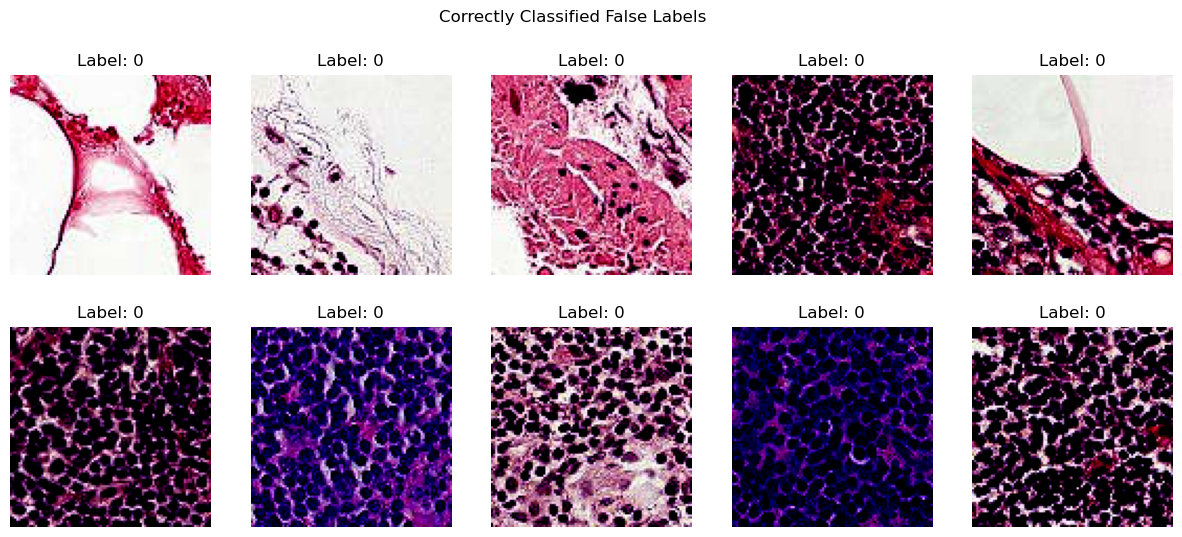

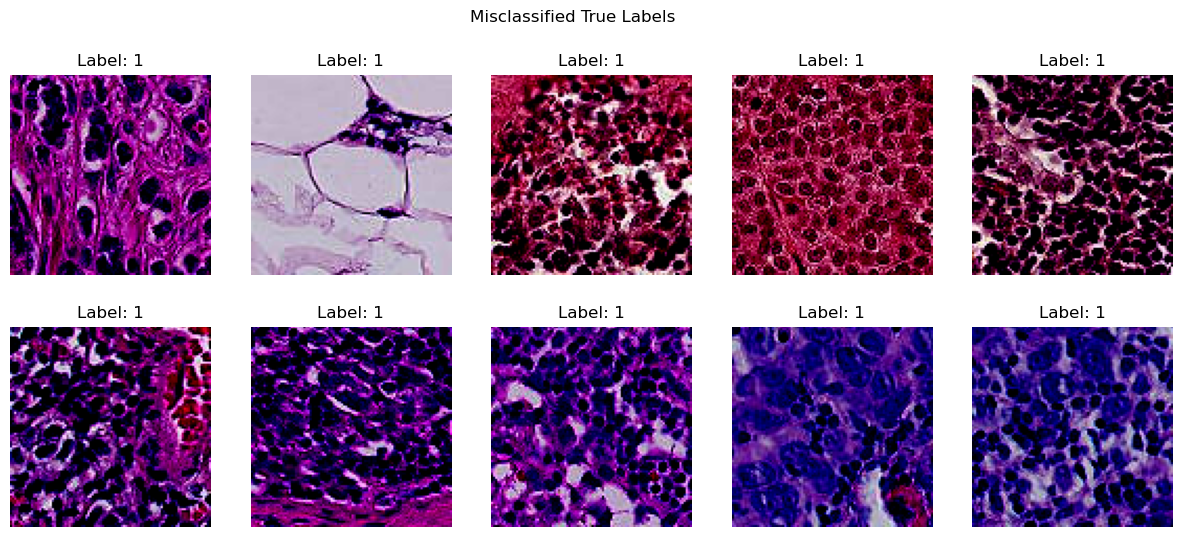

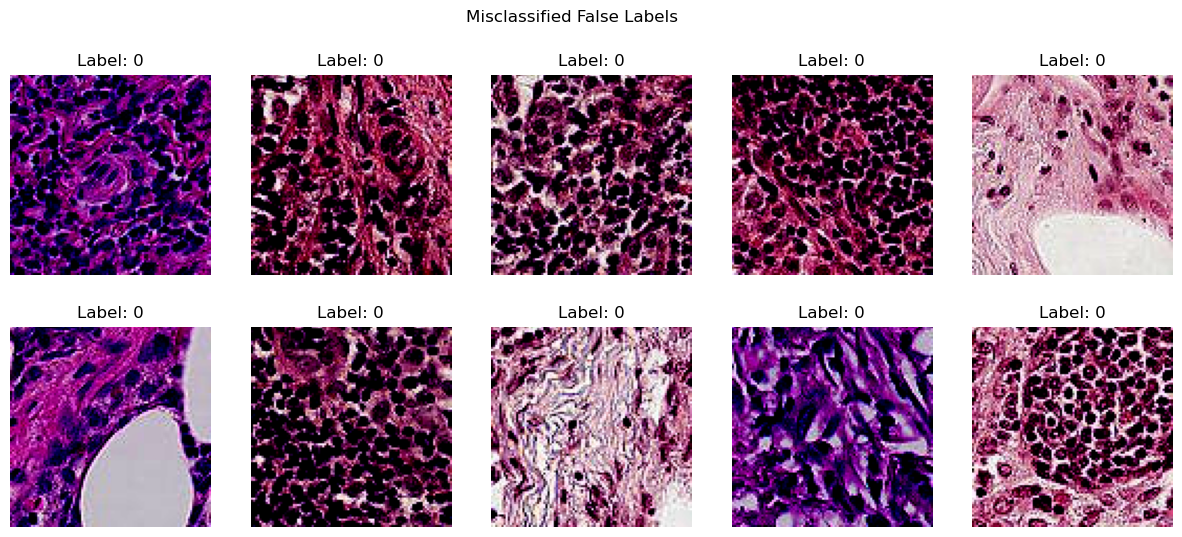

In [90]:
def plot_images(image_list, title):
    plt.figure(figsize=(15, 6))  # Adjust the size as needed
    plt.suptitle(title)
    
    for i, (image, label) in enumerate(image_list):
        if i >= 10:  # Limit to first 10 images
            break
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns, i-th plot
        plt.imshow(image.numpy().transpose(1, 2, 0))  # Convert tensor to image
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.show()
plot_images(correct_true_label, "Correctly Classified True Labels")
plot_images(correct_false_label, "Correctly Classified False Labels")
plot_images(incorrect_true_label, "Misclassified True Labels")
plot_images(incorrect_false_label, "Misclassified False Labels")
